In [ ]:
!pip install pandas numpy scikit-learn statsmodels

<ipython-input-3-e7c2b858625c>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['treatment'] = (cleaned_data['win_prob'] > 0.5).astype(int)
<ipython-input-3-e7c2b858625c>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['propensity_score'] = logit_model_ps.predict_proba(X_scaled)[:, 1]


Estimated Average Treatment Effect on the Treated (ATT) for usnews_academic_rep_new: 1.0655736923217773


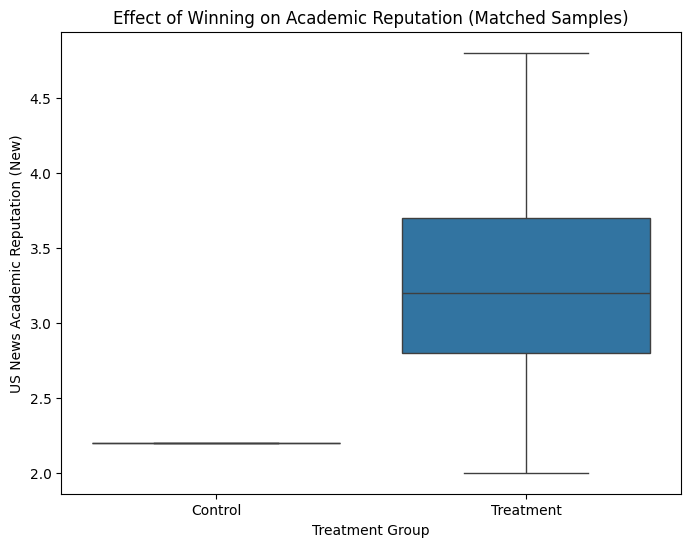

In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
college_data = pd.read_stata('/content/college data.dta')
covers_data = pd.read_stata('/content/covers_data.dta')

# Preparing the covers_data by dropping rows with missing values in 'line' and 'win'
covers_data_clean = covers_data.dropna(subset=['line', 'win'])

# Logistic Regression Model to predict win probabilities
logit_model = LogisticRegression()
logit_model.fit(covers_data_clean[['line']], covers_data_clean['win'])

# Adding the predicted probabilities back to the original dataset (for all data)
covers_data['win_prob'] = logit_model.predict_proba(covers_data[['line']].fillna(0))[:, 1]

# Preparing and merging the datasets on 'teamname' and 'year'
covers_data['year'] = covers_data['year'].astype(int)
merged_data = college_data.merge(covers_data[['teamname', 'year', 'win_prob']], on=['teamname', 'year'], how='left')

# Fill NaN values in 'win_prob' with the median
merged_data['win_prob'].fillna(merged_data['win_prob'].median(), inplace=True)

# Instead of dropping rows, select rows where 'usnews_academic_rep_new' is not NaN
cleaned_data = merged_data.dropna(subset=['usnews_academic_rep_new'])

# Define binary treatment based on 'win_prob'
cleaned_data['treatment'] = (cleaned_data['win_prob'] > 0.5).astype(int)

# Prepare features for propensity score estimation
X = cleaned_data[['win_prob']]
y = cleaned_data['treatment']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression to estimate propensity scores
logit_model_ps = LogisticRegression()
logit_model_ps.fit(X_scaled, y)
cleaned_data['propensity_score'] = logit_model_ps.predict_proba(X_scaled)[:, 1]

# Efficient Nearest-Neighbor Matching using sklearn
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
treatment_scores = cleaned_data[cleaned_data['treatment'] == 1]['propensity_score'].values.reshape(-1, 1)
control_scores = cleaned_data[cleaned_data['treatment'] == 0]['propensity_score'].values.reshape(-1, 1)

# Fit on control group scores
nn.fit(control_scores)

# Find nearest neighbor for each treatment sample
_, indices = nn.kneighbors(treatment_scores)

# Extract matched control indices
matched_control_indices = indices.flatten()
matched_control = cleaned_data[cleaned_data['treatment'] == 0].iloc[matched_control_indices]
treatment = cleaned_data[cleaned_data['treatment'] == 1]

# Combine matched treatment and control samples
matched_data = pd.concat([treatment, matched_control])
# Calculate the Average Treatment Effect on the Treated (ATT) for academic reputation
att = (matched_data[matched_data['treatment'] == 1]['usnews_academic_rep_new'].mean() -
       matched_data[matched_data['treatment'] == 0]['usnews_academic_rep_new'].mean())
print(f"Estimated Average Treatment Effect on the Treated (ATT) for usnews_academic_rep_new: {att}")

# Visualize the distribution of 'usnews_academic_rep_new' for the matched samples
plt.figure(figsize=(8, 6))
sns.boxplot(x='treatment', y='usnews_academic_rep_new', data=matched_data)
plt.title('Effect of Winning on Academic Reputation (Matched Samples)')
plt.xlabel('Treatment Group')
plt.xticks([0, 1], ['Control', 'Treatment'])
plt.ylabel('US News Academic Reputation (New)')
plt.show()

# New Section

Logistic Regression Model Accuracy: 0.7466875871687587


<ipython-input-7-ec15ad4cf7f4>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['treatment'] = (cleaned_data['win_prob'] > 0.5).astype(int)
<ipython-input-7-ec15ad4cf7f4>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['propensity_score'] = logit_model_ps.predict_proba(X_scaled)[:, 1]


Estimated Average Treatment Effect on the Treated (ATT) for alumni_giving_rate: 11.610228146629069


<ipython-input-7-ec15ad4cf7f4>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_data_no_outliers['acceptance_rate'].fillna(matched_data_no_outliers['acceptance_rate'].median(), inplace=True)
<ipython-input-7-ec15ad4cf7f4>:108: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cleaned_data[cleaned_data['treatment'] == 0]['propensity_score'], label='Control (Before Matching)', shade=True, bw_adjust=0.5)
<ipython-input-7-ec15ad4cf7f4>:109: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cleaned_data[cleaned_data['treatment'] == 1]['propensity_score'], label=

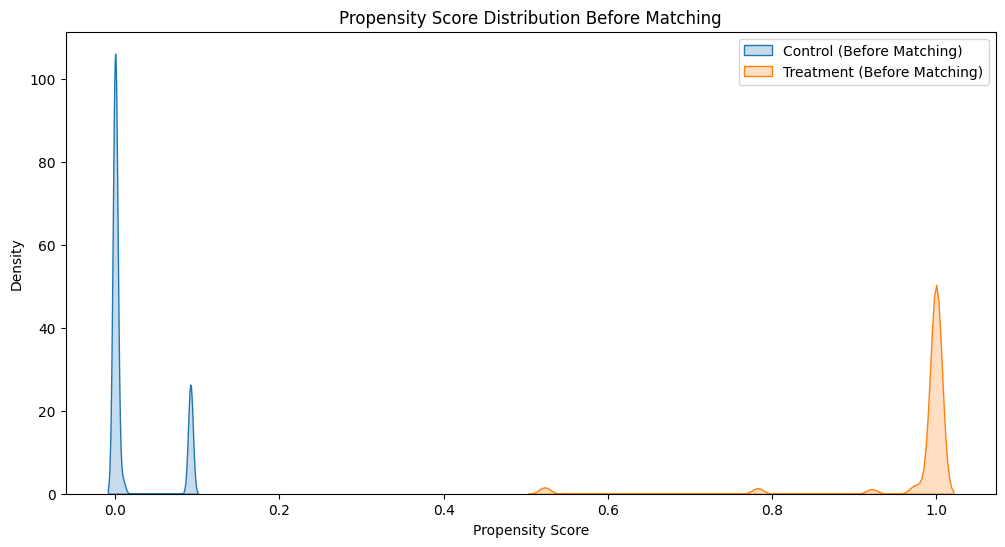

<ipython-input-7-ec15ad4cf7f4>:118: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(matched_data_no_outliers[matched_data_no_outliers['treatment'] == 0]['propensity_score'], label='Control (After Matching)', shade=True, bw_adjust=0.5)
<ipython-input-7-ec15ad4cf7f4>:118: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(matched_data_no_outliers[matched_data_no_outliers['treatment'] == 0]['propensity_score'], label='Control (After Matching)', shade=True, bw_adjust=0.5)
<ipython-input-7-ec15ad4cf7f4>:119: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(matched_data_no_outliers[matched_data_no_outliers['treatment'] == 1]['propensity_score'], label='Treatment (After Matchi

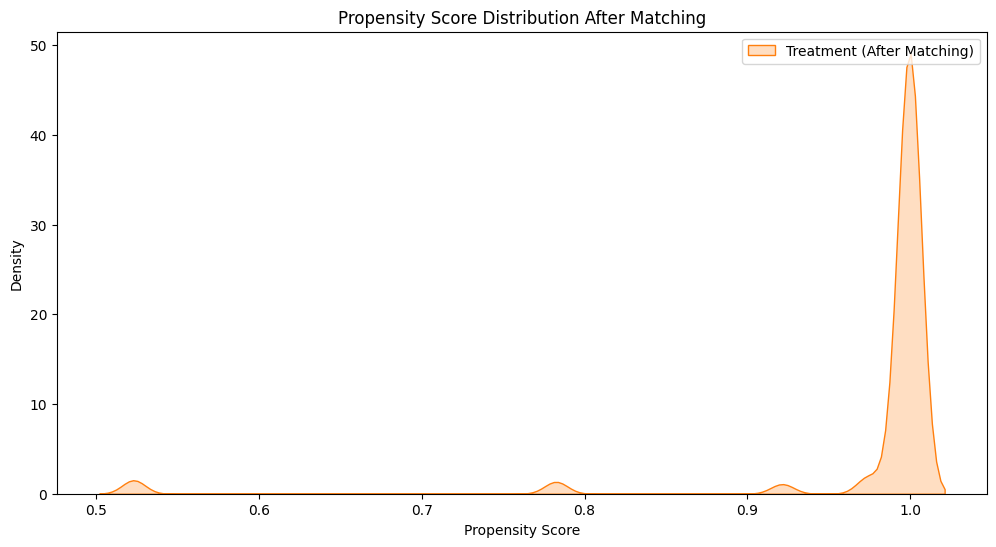

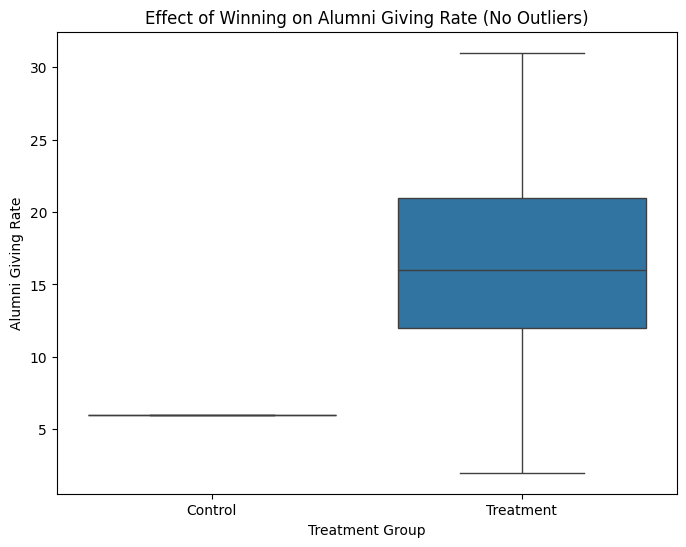

Before Matching:
       Group  Count  Propensity Score Mean  Propensity Score STD  \
0    Control   8941               0.017960              0.036051   
1  Treatment   7802               0.979418              0.082756   

   Alumni Giving Rate Mean  
0                16.960966  
1                17.610228  

After Matching:
       Group  Count  Propensity Score Mean  Propensity Score STD  \
0    Control   7802               0.091711              0.000000   
1  Treatment   7055               0.979286              0.083011   

   Alumni Giving Rate Mean  
0                 6.000000  
1                16.313253  


In [7]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Load the datasets
college_data = pd.read_stata('/content/college data.dta')
covers_data = pd.read_stata('/content/covers_data.dta')

# Preparing the covers_data by dropping rows with missing values in 'line' and 'win'
covers_data_clean = covers_data.dropna(subset=['line', 'win'])

# Splitting the dataset into training and testing sets for logistic regression
X_train, X_test, y_train, y_test = train_test_split(
    covers_data_clean[['line']], covers_data_clean['win'], test_size=0.2, random_state=42)

# Logistic Regression Model
logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)

# Predicting the win probabilities on the test set and calculating accuracy
y_pred_proba = logit_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, (y_pred_proba > 0.5).astype(int))
print(f"Logistic Regression Model Accuracy: {accuracy}")

# Adding the predicted probabilities back to the original dataset (for all data)
covers_data['win_prob'] = logit_model.predict_proba(covers_data[['line']].fillna(0))[:, 1]

# Preparing and merging the datasets on 'teamname' and 'year'
covers_data['year'] = covers_data['year'].astype(int)
merged_data = college_data.merge(covers_data[['teamname', 'year', 'win_prob']], on=['teamname', 'year'], how='left')

# Fill NaN values in 'win_prob' with the median
merged_data['win_prob'].fillna(merged_data['win_prob'].median(), inplace=True)

# Drop rows where 'alumni_giving_rate' is NaN
cleaned_data = merged_data.dropna(subset=['alumni_giving_rate'])

# Define binary treatment based on 'win_prob'
cleaned_data['treatment'] = (cleaned_data['win_prob'] > 0.5).astype(int)

# Prepare features for propensity score estimation
X = cleaned_data[['win_prob']]
y = cleaned_data['treatment']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression to estimate propensity scores
logit_model_ps = LogisticRegression()
logit_model_ps.fit(X_scaled, y)
cleaned_data['propensity_score'] = logit_model_ps.predict_proba(X_scaled)[:, 1]

# Efficient Nearest-Neighbor Matching using sklearn
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
treatment_scores = cleaned_data[cleaned_data['treatment'] == 1]['propensity_score'].values.reshape(-1, 1)
control_scores = cleaned_data[cleaned_data['treatment'] == 0]['propensity_score'].values.reshape(-1, 1)

# Fit on control group scores
nn.fit(control_scores)

# Find nearest neighbor for each treatment sample
_, indices = nn.kneighbors(treatment_scores)

# Extract matched control indices
matched_control_indices = indices.flatten()
matched_control = cleaned_data[cleaned_data['treatment'] == 0].iloc[matched_control_indices]
treatment = cleaned_data[cleaned_data['treatment'] == 1]

# Combine matched treatment and control samples
matched_data = pd.concat([treatment, matched_control])

# Calculate the Average Treatment Effect on the Treated (ATT)
att = (matched_data[matched_data['treatment'] == 1]['alumni_giving_rate'].mean() -
       matched_data[matched_data['treatment'] == 0]['alumni_giving_rate'].mean())

print(f"Estimated Average Treatment Effect on the Treated (ATT) for alumni_giving_rate: {att}")
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate IQR for 'alumni_giving_rate'
Q1 = matched_data['alumni_giving_rate'].quantile(0.25)
Q3 = matched_data['alumni_giving_rate'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
matched_data_no_outliers = matched_data[(matched_data['alumni_giving_rate'] >= lower_bound) &
                                        (matched_data['alumni_giving_rate'] <= upper_bound)]
# Dropping columns with too many missing values (e.g., more than 50% missing)
threshold = len(matched_data_no_outliers) * 0.5
matched_data_no_outliers = matched_data_no_outliers.dropna(thresh=threshold, axis=1)

# Filling missing values in 'acceptance_rate' with the median value
matched_data_no_outliers['acceptance_rate'].fillna(matched_data_no_outliers['acceptance_rate'].median(), inplace=True)

# Dropping rows where 'top10pct' is NaN since it's an important variable but has some missing values
matched_data_no_outliers = matched_data_no_outliers.dropna(subset=['top10pct'])

# KDE plots for propensity score distribution
plt.figure(figsize=(12, 6))
sns.kdeplot(cleaned_data[cleaned_data['treatment'] == 0]['propensity_score'], label='Control (Before Matching)', shade=True, bw_adjust=0.5)
sns.kdeplot(cleaned_data[cleaned_data['treatment'] == 1]['propensity_score'], label='Treatment (Before Matching)', shade=True, bw_adjust=0.5)
plt.title('Propensity Score Distribution Before Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# After matching
plt.figure(figsize=(12, 6))
sns.kdeplot(matched_data_no_outliers[matched_data_no_outliers['treatment'] == 0]['propensity_score'], label='Control (After Matching)', shade=True, bw_adjust=0.5)
sns.kdeplot(matched_data_no_outliers[matched_data_no_outliers['treatment'] == 1]['propensity_score'], label='Treatment (After Matching)', shade=True, bw_adjust=0.5)
plt.title('Propensity Score Distribution After Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()


# Boxplot for Effect of Winning on Alumni Giving Rate without outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x='treatment', y='alumni_giving_rate', data=matched_data_no_outliers)
plt.title('Effect of Winning on Alumni Giving Rate (No Outliers)')
plt.xlabel('Treatment Group')
plt.xticks([0, 1], ['Control', 'Treatment'])
plt.ylabel('Alumni Giving Rate')
plt.show()

stats_before_matching = {
    'Group': ['Control', 'Treatment'],
    'Count': [cleaned_data[cleaned_data['treatment'] == 0].shape[0], cleaned_data[cleaned_data['treatment'] == 1].shape[0]],
    'Propensity Score Mean': [cleaned_data[cleaned_data['treatment'] == 0]['propensity_score'].mean(), cleaned_data[cleaned_data['treatment'] == 1]['propensity_score'].mean()],
    'Propensity Score STD': [cleaned_data[cleaned_data['treatment'] == 0]['propensity_score'].std(), cleaned_data[cleaned_data['treatment'] == 1]['propensity_score'].std()],
    'Alumni Giving Rate Mean': [cleaned_data[cleaned_data['treatment'] == 0]['alumni_giving_rate'].mean(), cleaned_data[cleaned_data['treatment'] == 1]['alumni_giving_rate'].mean()],
}

stats_before_matching_df = pd.DataFrame(stats_before_matching)
print("Before Matching:")
print(stats_before_matching_df)

# Calculate the statistics after matching
stats_after_matching = {
    'Group': ['Control', 'Treatment'],
    'Count': [matched_data_no_outliers[matched_data_no_outliers['treatment'] == 0].shape[0], matched_data_no_outliers[matched_data_no_outliers['treatment'] == 1].shape[0]],
    'Propensity Score Mean': [matched_data_no_outliers[matched_data_no_outliers['treatment'] == 0]['propensity_score'].mean(), matched_data_no_outliers[matched_data_no_outliers['treatment'] == 1]['propensity_score'].mean()],
    'Propensity Score STD': [matched_data_no_outliers[matched_data_no_outliers['treatment'] == 0]['propensity_score'].std(), matched_data_no_outliers[matched_data_no_outliers['treatment'] == 1]['propensity_score'].std()],
    'Alumni Giving Rate Mean': [matched_data_no_outliers[matched_data_no_outliers['treatment'] == 0]['alumni_giving_rate'].mean(), matched_data_no_outliers[matched_data_no_outliers['treatment'] == 1]['alumni_giving_rate'].mean()],
}

stats_after_matching_df = pd.DataFrame(stats_after_matching)
print("\nAfter Matching:")
print(stats_after_matching_df)
